In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
train_data = pd.read_csv('train.csv')

train_data.sample(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1072,1169,9,1.0,38.533589,18.689752,10.0,8,16.0,1998,0.069753,B,B,53,13670,4,NaN,1,11,B,195593.217821
9990,15233,1,3.0,57.373889,39.688445,5.0,2,5.0,1962,0.036270,B,B,6,1318,1,200.0,1,1,B,163807.542987
8942,5834,9,2.0,68.578100,NaN,1.0,11,1.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,208836.500116
1667,3656,192,1.0,35.638404,24.736845,5.0,11,9.0,1965,0.225825,A,B,41,6558,7,1548.0,3,2,B,137505.343314
5371,10767,9,1.0,43.921584,43.574444,1.0,11,1.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,133531.886165
3600,14820,9,1.0,44.838137,24.352631,8.0,14,14.0,1989,0.136244,B,B,11,2370,0,NaN,0,1,B,155126.948047
884,3915,29,3.0,85.438978,56.916346,7.0,6,5.0,1956,0.069660,B,B,31,6119,4,NaN,1,2,B,334184.361783
4241,2904,6,2.0,65.929865,NaN,1.0,3,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,174858.771704
4961,16624,28,3.0,87.043971,51.071743,11.0,9,23.0,2006,0.333892,B,B,30,6564,1,NaN,0,0,B,508084.108360
8131,4991,93,3.0,167.767027,NaN,1.0,1,1.0,1977,0.004949,B,B,0,186,0,NaN,0,0,B,211180.794219


### Описание датасета
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int64   
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  float64 
 3   Square         10000 non-null  float64 
 4   LifeSquare     7887 non-null   float64 
 5   KitchenSquare  10000 non-null  float64 
 6   Floor          10000 non-null  int64   
 7   HouseFloor     10000 non-null  float64 
 8   HouseYear      10000 non-null  int64   
 9   Ecology_1      10000 non-null  float64 
 10  Ecology_2      10000 non-null  object  
 11  Ecology_3      10000 non-null  object  
 12  Social_1       10000 non-null  int64   
 13  Social_2       10000 non-null  int64   
 14  Social_3       10000 non-null  int64   
 15  Healthcare_1   5202 non-null   float64 
 16  Helthcare_2    10000 non-null  int64   
 17  Shops_1        10000 non-null  i

In [24]:
train_data.DistrictId = train_data.DistrictId.astype("category")

In [25]:
train_data.isna().sum()[train_data.isna().sum() > 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

In [26]:
df_num_features = train_data.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


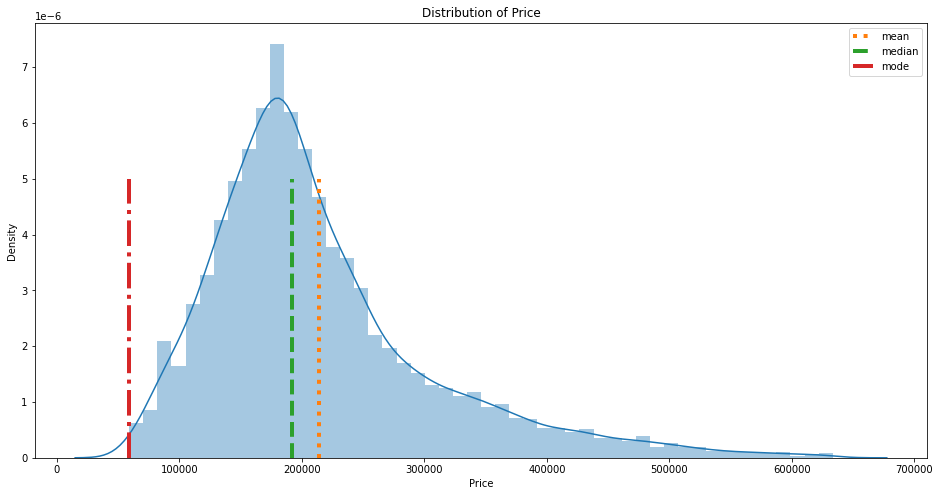

In [29]:
plt.figure(figsize = (16, 8))

sns.distplot(train_data['Price'], bins=50)

target_mean = round(train_data['Price'].mean(), 2)
target_median = train_data['Price'].median()
target_mode = train_data['Price'].mode()[0]

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

In [31]:
target_bins = train_data['Price'] // 10000 * 10000
target_adjusted_mode = target_bins.mode()[0]

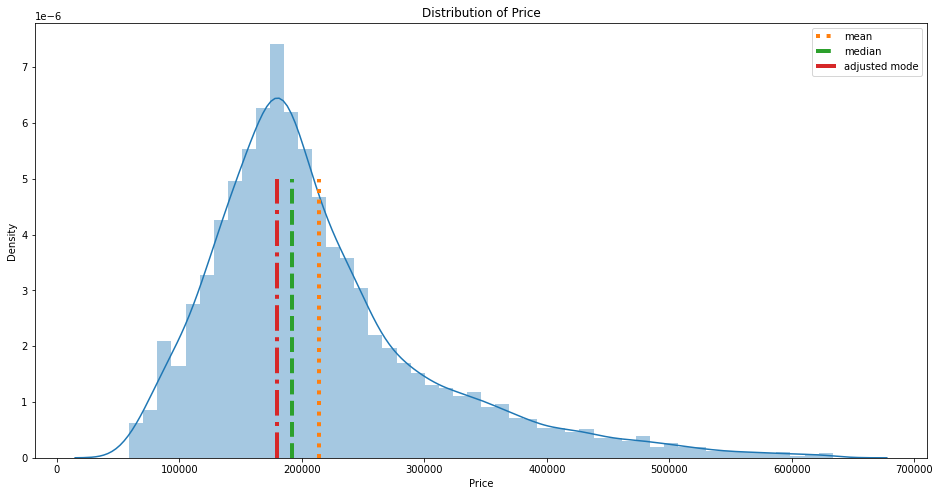

In [33]:
plt.figure(figsize = (16, 8))

sns.distplot(train_data['Price'], bins=50) 

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_adjusted_mode] * 10, y, label='adjusted mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()